# SVD implementation

In [1]:
import surprise
from surprise import SVD
from surprise import Dataset, accuracy, Reader

from surprise.model_selection import cross_validate, KFold, GridSearchCV
from collections import defaultdict

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
"""my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)"""

'my_seed = 0\nrandom.seed(my_seed)\nnp.random.seed(my_seed)'

In [3]:
def _print(message, verbose):
    if verbose:
        print(message)
        
def load_dataset(data_f):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating"]] = pd.read_json(data_f)[["userID", "itemID", "rating"]]
    except:
        df = pd.read_json(data_f)
        df.drop_duplicates(subset=["userID", "itemID"], inplace=True)
    return df

def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df

def build_data(df):
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df, reader)
    return data

In [4]:
def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.
    """
    df = load_dataset(fp)
    df = filter_to_sparsity(df, sparsity_percentage)
    data = build_data(df)
    
    return data

### Precision and recall

In [5]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
    
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [6]:
def DCG(query_relevancy_labels, k):
    # Use log with base 2
    value=min(k,len(query_relevancy_labels))
    sum1=0
    for i in range(value):
      sum1=sum1+((query_relevancy_labels[i])/(np.log2(2+i)))

    return sum1

def NDCG(query_relevancy_labels, k):
    sorted_list= np.sort(query_relevancy_labels)[::-1]
    dcg1 = DCG(query_relevancy_labels, k)
    dcg2 = DCG(sorted_list, k)
    if dcg2 == 0:
      return 0
    else:
      return dcg1/dcg2

In [7]:
def ndcg_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    dcg = dict()
    ndcg = dict()
    for uid, user_ratings in user_est_true.items():
        rel=[]

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        for _, true_r in user_ratings:
          if true_r>=threshold:
            rel.append(true_r)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        #print(rel)

        ndcg[uid] = NDCG(rel, k)

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        #recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return ndcg

### Simulation

In [16]:
results = {0.75:[[],[],[]], 0.80:[[],[],[]] , 0.85:[[],[],[]],\
           0.90:[[],[],[]] , 0.95:[[],[],[]]}
spt = [0.75, 0.8 , 0.85, 0.9 , 0.95]

In [17]:
for inter in range(20):
    for spar in spt:
        data = data_loading_pipeline("../data/AMAZON_FASHION_5.71.268.json",round(spar,2))

        raw_ratings = data.raw_ratings
        random.shuffle(raw_ratings)
        #A = 80%, B=20%
        threshold = int(.8 * len(raw_ratings))
        A_raw_ratings = raw_ratings[:threshold]
        B_raw_ratings = raw_ratings[threshold:]
        data.raw_ratings = A_raw_ratings

        param_grid = {'n_epochs': [20,30,40,50], 'lr_all': [0.005,0.05],'reg_all': [0.1, 0.4]}
        gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
        gs.fit(data)

        svd = gs.best_estimator['rmse']
        trainset = data.build_full_trainset()
        svd.fit(trainset)

        predictions = svd.test(trainset.build_testset())
        print('Biased accuracy on A,', end= '  ')
        accuracy.rmse(predictions)

        testset = data.construct_testset(B_raw_ratings)
        predictions = svd.test(testset)
        print('Unbiased accuracy on B,', end= ' ')
        accuracy.rmse(predictions)

        precisions, recalls = precision_recall_at_k(predictions, k=100, threshold=4)
        ndcg_val = ndcg_at_k(predictions, k=100, threshold=4)
        precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
        recallk=(sum(rec for rec in recalls.values()) / len(recalls))
        ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
        results[round(spar,2)][0].append(precisionk)
        results[round(spar,2)][1].append(recallk)
        results[round(spar,2)][2].append(ndcgk)
    print(results)

To obtain a sparsity of 75.0% we need to drop 391 ratings
Biased accuracy on A,  RMSE: 0.0828
Unbiased accuracy on B, RMSE: 0.1440
To obtain a sparsity of 80.0% we need to drop 914 ratings
Biased accuracy on A,  RMSE: 0.0846
Unbiased accuracy on B, RMSE: 0.1251
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Biased accuracy on A,  RMSE: 0.0882
Unbiased accuracy on B, RMSE: 0.3111
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0837
Unbiased accuracy on B, RMSE: 0.1357
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0854
Unbiased accuracy on B, RMSE: 0.2386
{0.75: [[0.8061224489795918], [0.8027210884353742], [0.8401360544217688]], 0.8: [[0.8075601374570447], [0.802405498281787], [0.8281786941580757]], 0.85: [[0.8259109311740891], [0.8259109311740891], [0.8259109311740891]], 0.9: [[0.8243243243243243], [0.8243243243243243], [0.8243243243243243]], 0.95: [[0.8333333333333334], [0.8333333333333334

Biased accuracy on A,  RMSE: 0.0844
Unbiased accuracy on B, RMSE: 0.1493
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0838
Unbiased accuracy on B, RMSE: 0.1951
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0878
Unbiased accuracy on B, RMSE: 0.2794
{0.75: [[0.8061224489795918, 0.8191126279863481, 0.8360655737704918, 0.8, 0.813953488372093, 0.8237179487179487], [0.8027210884353742, 0.8162684869169512, 0.8327868852459016, 0.7836111111111111, 0.8128460686600222, 0.8237179487179487], [0.8401360544217688, 0.825938566552901, 0.839344262295082, 0.8566666666666667, 0.8272425249169435, 0.8269230769230769]], 0.8: [[0.8075601374570447, 0.8333333333333334, 0.8345588235294118, 0.8369565217391305, 0.8290909090909091, 0.832089552238806], [0.802405498281787, 0.8315972222222222, 0.8345588235294118, 0.8369565217391305, 0.8242424242424243, 0.8302238805970149], [0.8281786941580757, 0.8368055555555556, 0.838235294117647

Biased accuracy on A,  RMSE: 0.0900
Unbiased accuracy on B, RMSE: 0.1703
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0841
Unbiased accuracy on B, RMSE: 0.2269
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0869
Unbiased accuracy on B, RMSE: 0.3472
{0.75: [[0.8061224489795918, 0.8191126279863481, 0.8360655737704918, 0.8, 0.813953488372093, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.825503355704698], [0.8027210884353742, 0.8162684869169512, 0.8327868852459016, 0.7836111111111111, 0.8128460686600222, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.8227069351230425], [0.8401360544217688, 0.825938566552901, 0.839344262295082, 0.8566666666666667, 0.8272425249169435, 0.8269230769230769, 0.8388157894736842, 0.8127090301003345, 0.8489932885906041]], 0.8: [[0.8075601374570447, 0.8333333333333334, 0.8345588235294118, 0.8369565217391305, 0.8290909090909091, 0.832089552238806, 0

Biased accuracy on A,  RMSE: 0.0832
Unbiased accuracy on B, RMSE: 0.1589
To obtain a sparsity of 80.0% we need to drop 914 ratings
Biased accuracy on A,  RMSE: 0.0903
Unbiased accuracy on B, RMSE: 0.2511
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Biased accuracy on A,  RMSE: 0.0877
Unbiased accuracy on B, RMSE: 0.2740
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0919
Unbiased accuracy on B, RMSE: 0.2328
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0845
Unbiased accuracy on B, RMSE: 0.4889
{0.75: [[0.8061224489795918, 0.8191126279863481, 0.8360655737704918, 0.8, 0.813953488372093, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.825503355704698, 0.8590604026845637, 0.8158783783783784, 0.819672131147541], [0.8027210884353742, 0.8162684869169512, 0.8327868852459016, 0.7836111111111111, 0.8128460686600222, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.82270

Biased accuracy on A,  RMSE: 0.0904
Unbiased accuracy on B, RMSE: 0.1427
To obtain a sparsity of 80.0% we need to drop 914 ratings
Biased accuracy on A,  RMSE: 0.0823
Unbiased accuracy on B, RMSE: 0.3935
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Biased accuracy on A,  RMSE: 0.0800
Unbiased accuracy on B, RMSE: 0.1086
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0902
Unbiased accuracy on B, RMSE: 0.1574
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0865
Unbiased accuracy on B, RMSE: 0.1825
{0.75: [[0.8061224489795918, 0.8191126279863481, 0.8360655737704918, 0.8, 0.813953488372093, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.825503355704698, 0.8590604026845637, 0.8158783783783784, 0.819672131147541, 0.8106312292358804, 0.7905405405405406], [0.8027210884353742, 0.8162684869169512, 0.8327868852459016, 0.7836111111111111, 0.8128460686600222, 0.8237179487179487, 0.83881

Biased accuracy on A,  RMSE: 0.0863
Unbiased accuracy on B, RMSE: 0.1397
To obtain a sparsity of 80.0% we need to drop 914 ratings
Biased accuracy on A,  RMSE: 0.0857
Unbiased accuracy on B, RMSE: 0.2613
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Biased accuracy on A,  RMSE: 0.0843
Unbiased accuracy on B, RMSE: 0.2143
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0810
Unbiased accuracy on B, RMSE: 0.2362
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0927
Unbiased accuracy on B, RMSE: 0.4536
{0.75: [[0.8061224489795918, 0.8191126279863481, 0.8360655737704918, 0.8, 0.813953488372093, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.825503355704698, 0.8590604026845637, 0.8158783783783784, 0.819672131147541, 0.8106312292358804, 0.7905405405405406, 0.8033898305084746, 0.8151815181518152], [0.8027210884353742, 0.8162684869169512, 0.8327868852459016, 0.7836111111111111, 0.81284

Biased accuracy on A,  RMSE: 0.0827
Unbiased accuracy on B, RMSE: 0.1405
To obtain a sparsity of 80.0% we need to drop 914 ratings
Biased accuracy on A,  RMSE: 0.0918
Unbiased accuracy on B, RMSE: 0.2293
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Biased accuracy on A,  RMSE: 0.0885
Unbiased accuracy on B, RMSE: 0.1735
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0878
Unbiased accuracy on B, RMSE: 0.1365
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0851
Unbiased accuracy on B, RMSE: 0.1748
{0.75: [[0.8061224489795918, 0.8191126279863481, 0.8360655737704918, 0.8, 0.813953488372093, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.825503355704698, 0.8590604026845637, 0.8158783783783784, 0.819672131147541, 0.8106312292358804, 0.7905405405405406, 0.8033898305084746, 0.8151815181518152, 0.8246753246753247, 0.8058252427184466], [0.8027210884353742, 0.8162684869169512, 0.83278

Biased accuracy on A,  RMSE: 0.0882
Unbiased accuracy on B, RMSE: 0.1394
To obtain a sparsity of 80.0% we need to drop 914 ratings
Biased accuracy on A,  RMSE: 0.0804
Unbiased accuracy on B, RMSE: 0.1194
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Biased accuracy on A,  RMSE: 0.0928
Unbiased accuracy on B, RMSE: 0.2799
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0859
Unbiased accuracy on B, RMSE: 0.2669
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0839
Unbiased accuracy on B, RMSE: 0.3654
{0.75: [[0.8061224489795918, 0.8191126279863481, 0.8360655737704918, 0.8, 0.813953488372093, 0.8237179487179487, 0.8388157894736842, 0.8093645484949833, 0.825503355704698, 0.8590604026845637, 0.8158783783783784, 0.819672131147541, 0.8106312292358804, 0.7905405405405406, 0.8033898305084746, 0.8151815181518152, 0.8246753246753247, 0.8058252427184466, 0.8304498269896193, 0.7814569536423841], [0.80272

In [21]:
r_pres = []
r_recl = []
r_ndcg = []
for i in results:
    r_pres.append(np.mean(results[i][0]))
    r_recl.append(np.mean(results[i][1]))
    r_ndcg.append(np.mean(results[i][2]))
print(r_pres, r_recl, r_ndcg)

[0.8164708580086405, 0.8279003781354783, 0.8241895211414627, 0.8131791060924509, 0.8270781634411728] [0.8136107876780351, 0.8255896741711106, 0.8218021741314493, 0.8118111387606917, 0.8256001082836498] [0.8343806470386875, 0.8354741263567881, 0.8348184251146578, 0.8274156806402948, 0.8371806161728342]


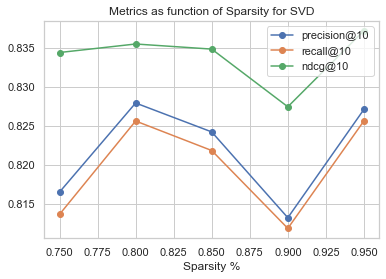

In [22]:
sns.set(style='whitegrid')
plt.plot(spt,r_pres,label="precision@10", marker = "o")
plt.plot(spt,r_recl,label="recall@10", marker = "o")
plt.plot(spt,r_ndcg,label="ndcg@10", marker = "o")

plt.title("Metrics as function of Sparsity for SVD")
plt.xlabel("Sparsity %")
plt.legend()
#plt.savefig(\"../metrics_over_sparsity.png\")

plt.show()